# 0. TO DO

* EDA (DATA PREPROCESSING: Check Ouliers,)
* FEATURE ENGINEERING
* MODEL SELECTION & TRAINING



<br />

---
# **1. LIBRARIES & DATA IMPORT**
---

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import mahalanobis


1.1. IMPORT DATASET FROM CSV

In [12]:
# file path
csv_path = "../dataset/TAIPEI_diabetes.csv" 

# create dataframe to start exploring
diabete_df = pd.read_csv(csv_path)

# check if the dataset is correctly created
# diabete_df

1.2. Functions to be modularized

In [76]:
# A function that allows to check if the data points data types corresponds to their columns' data type
def dtype_per_column(df):
    # pour modifier l'affichage en tableau
    new_df = pd.DataFrame()
    new_df["column"] = df.columns
    type_count = []
    for col in df.columns:
        dtype_count = {}

        for i in df[col]:
            dtype_name = type(i).__name__
            if dtype_name in dtype_count:
                dtype_count[dtype_name] = dtype_count[dtype_name] + 1
            else:
                dtype_count[dtype_name] = 1
       
        for dtype_name in dtype_count:
            # Pour modifier l'affichage
            type_count.append(f"{dtype_name}:{dtype_count[dtype_name]}")
    new_df["type_count"] = type_count
    return new_df.T

# A function that allows to generate and compare descriptive statistics for a specific column across multiple dataframes
def compare_statistics_per_col(dataframes, dataframes_names, column):
    descriptive_statistics = []
    
    for df in dataframes:
        statistics = df[column].describe()
        descriptive_statistics.append(statistics)
    
    result = pd.concat(descriptive_statistics, axis=1, keys=dataframes_names)

    print("---" * 10)
    print(f"Comparison of descriptive statistics for \x1B[4m{column}\x1B[0m:")
    print("---" * 10)
    return result

# A function that allows to generate and compare histograms for a specific column across multiple dataframes
def compare_histograms_per_col(dataframes, dataframes_names, column):

    n = len(dataframes)
    fig, axes = plt.subplots(ncols=n, nrows=1, figsize=(5 * n, 4))
    
    for i in range(n):
        ax = axes[i]
        df = dataframes[i]
        name = dataframes_names[i]
        sns.histplot(data=df, x=column, ax=ax, kde=True)
        ax.set_title(f"{name}")
    
    print("---" * 10)
    print(f"Comparison of data distributions for \x1B[4m{column}\x1B[0m:")
    print("---" * 10)
    
    plt.tight_layout()
    plt.show()


# A function that allows to check of the top 10 most frequent values per column in a dataframe
def top_10_frequent_values(df,col_name = None):#add col_name, optional parameter to print only values for selected column
    if(col_name is None):
        for col in df:
            print(f"Top 10 most frequent values for \x1B[4m{col}\x1B[0m::")
            print(df[col].value_counts().head(10))
            print("\n")
    else:
        print(f"Top 10 most frequent values for \x1B[4m{col_name}\x1B[0m::")
        print(df[col_name].value_counts().head(10))
        print("\n")
# A function that allow to check of duplicated data points per column
def duplicate_cells_per_column(df):
    for col in df.columns:
        print(f"{col}: {df[col].duplicated().sum()}")



<br />

---
# **2. INITIAL DATA OVERVIEW**
---

**This part is dedicated to get a general understanding of the data available and identification of the following:**
* general shape of the dataframe
* features (Measurments) available for the prediction of our target variable (i.e Diabetic or not);
* detecting NULL data points;
* columns' data types;
* check if the data point respects the data type of the column;
* duplicate values.

2.1. CHECK GENERAL SHAPE

In [ ]:
# Df sizing :  (1500 Lines & 10 columns)
diabete_df.shape

(15000, 10)

In [6]:
# Quick look at the first values of the df on hand
diabete_df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [7]:
# Quick look at the last values of the df on hand
diabete_df.tail(10)

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
14990,1220763,5,169,83,31,60,49.004793,0.187397,53,1
14991,1603490,0,114,53,34,40,44.760534,0.143487,23,0
14992,1202654,3,48,60,24,81,29.417154,0.159605,42,1
14993,1165919,1,128,59,21,182,19.766514,0.167280,53,0
14994,1453189,0,72,99,32,32,20.932808,0.545038,22,0
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0
14999,1386396,3,114,65,47,512,36.215437,0.147363,34,1


2.2. CHECK MISSING (NULL) VALUE

In [8]:
# First check of the NULL data points inside the columns and their data types
diabete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [9]:
# Second check of the NULL values
diabete_df.isna().sum()

PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64

In [31]:
# Check of the data types of data points per column
new_df = dtype_per_column(diabete_df)
new_df

,0,1,2,3,4,5,6,7,8,9
column,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
type_count,int:15000,int:15000,int:15000,int:15000,int:15000,int:15000,float:15000,float:15000,int:15000,int:15000


In [32]:
# Check of the duplicated rows
duplicate_rows = diabete_df.duplicated().sum()

print(f"Total duplicated rows: {duplicate_rows}.")

Total duplicated rows: 0.


In [39]:
# Check of duplicated data points per column
duplicate_cells_per_column(diabete_df)

PatientID: 105
Pregnancies: 14985
PlasmaGlucose: 14851
DiastolicBloodPressure: 14910
TricepsThickness: 14931
SerumInsulin: 14337
BMI: 0
DiabetesPedigree: 1
Age: 14944
Diabetic: 14998


### **INITIAL DATA OVERVIEW OBSERVATIONS**

* The studied dataset consists of 15 000 records in total.

* It has 10 columns, with all of them being of a numerical data type (8x int64 and 2x float64).

* The features are of numeric nature, both continuous (float) and discrete (int). The predictor is a categorical, binary data type.

* All the data points match the expected data types for their respective columns. Based on the preliminary notes documentation, these data types seem correct, given the nature of the features. Therefore, there is no need for type casting in order to normalize the data types.

* The dataset contains no NULL values or duplicate rows, allowing us to explore it further during the EDA phase, without additional manipulations at this stage.

* 2/3 of the dataset contains non-diabetic patients records (predictor variable), which may lead to a class imbalance, where a machine learning model is better at predicting the non-diabetic patients, rather than the diabetic ones. An approach that might be helpful in this case would be resampling.

* The target variable being of binary type will be encoded during the feature engineering phase.

* An interesting observation is that 105 PatientID values are duplicated, suggesting that some patients may have undergone multiple check-ups.

---
# **3. EXPLORATORY DATA ANALYSIS (EDA)**
---

**3.1 Closer look at the repeated PatientID**

**This part is dedicated to:**
* Take a closer look at the repeated PatientID to comprehend if some patient underwent multiple medial checkups.
* Decide what to do with the repeated PatientID values : keep them, reject them or adjust them.

In [41]:
# Creation of a df with only repeated patients, ordered by the PatientID and the original df index
df_repeated_patients = diabete_df[diabete_df.duplicated(subset="PatientID", keep=False)].sort_values(by="PatientID", ascending=True, kind="mergesort")
df_repeated_patients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 3350 to 10750
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               210 non-null    int64  
 1   Pregnancies             210 non-null    int64  
 2   PlasmaGlucose           210 non-null    int64  
 3   DiastolicBloodPressure  210 non-null    int64  
 4   TricepsThickness        210 non-null    int64  
 5   SerumInsulin            210 non-null    int64  
 6   BMI                     210 non-null    float64
 7   DiabetesPedigree        210 non-null    float64
 8   Age                     210 non-null    int64  
 9   Diabetic                210 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 18.0 KB


In [42]:
# Creation of an additional column with the number of occurences for doubled patients, incremented according to the original df index
df_repeated_patients["Occurence"] = df_repeated_patients.groupby("PatientID").cumcount() + 1

In [ ]:
# Detailed overview of the repeated patients, sorted by PatientID
print(df_repeated_patients.sort_values(by="PatientID").to_string())

       PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  Occurence
3350     1015338           10            104                      59                57           259  29.268008          0.820120   21         1          1
4867     1015338            1             76                      48                44            37  21.280339          0.079090   22         0          2
2736     1033352            0            157                      97                34           221  36.263025          0.182434   60         0          1
2799     1033352            9            111                     100                 8            79  31.445866          0.283731   38         1          2
2968     1054588            0            144                      55                10            41  18.662067          0.151034   22         0          1
12419    1054588            3             50                    

**Repeated PatientID observations**

* A closer examination of repeated patient data rejects the initial hypothesis that the same individual might have undergone a second check-up.

* According to preliminary notes, data collection occurred in two periods: 2018–2020 and 2021–2022, spanning exactly five years. However, for some repeated patients, the age gap far exceeds this threshold. For instance, Patient's 1033352 first record lists their age as 60, while the second records them as 38.

* Additionally, some patients show inconsistencies in pregnancy history despite their young age. For example, Patient 1015338 is recorded as having had 10 pregnancies at age 21, but in a subsequent record at age 22, the number of pregnancies is 0.

* We observed that the duplicated ID are propably differnet person due to the differnce value on DiabetePedigree for the same Occurence. The DiabetePedigree is computed from the family history & cannot change 

#### **Repeated PatientID data implications**:
* Because of the detected data anomalies, we will not keep the repeated patients records in their original form before passing it to the machine learning models.

* To determine the final treatment approach, we will check which features are most important for our prediction, and check if repeated patients belong to underrepresented groups in the EDA phase. If they do, we will standardize their values; otherwise, we will drop their records during feature engineering phase.

**3.2 Statistical Analysis**

**This part is dedicated to:**
* check & comment the statistical values of the entire DataSet

In [44]:
# generates statistics summary
diabete_df.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


#### **Statistical Parameters**:
* **Mean**: <br>
    **(Diabetic)**:  we can deduce that we have 1/3 (33%) of patient which are diabetic. this population in this dataset, leaving with diabete seems above the world satistic (about 269 million on 4 billion ~ 6.57% ) <br> 
    **(Age)** : the medium age is 30 however the median is 24. It means that in this dataset there are a few samples that are "senior". The third quartile is 35, which mean that 25% of the dataset are over 35. <br> 
    **(PlasmaGlucose)**: This measurement gives us the concentration of glucose in plasma.
In accordance with the dataset documentation, baseline blood glucose values (i.e. fasting blood glucose) are not provided in this dataset. However, we do have the values after ingestion of the glucose solution.<br> 
        Plasma Glucose World Health Organization values <br>
        1. < 140 mg/dL (7.8 mmol/L) → Normal <br>
        2. 140 - 199 mg/dL (7.8 - 11.0 mmol/L) →  Glucose intolerance (prediabetes) <br>
        3. ≥ 200 mg/dL (11.1 mmol/L) → Diabete <br>

* **MAX**: <br>
        (PlasmaGlucose): Since the maximum value of plasmaglucose (192) is lower than the one in the WHO standards for diabete diagnosis, we conclude that the dataset used another standard to determine the presence of Diabete. 
<br>










## **3.1 Univariate & bivariate analysis with the target**

**This part is dedicated to:**
* Explore the data more in detail, by examining each column individually and their relationship to the target value;
* Understand if the data on hand is better at predicting the diabetic or non-diabetic outcome.

In [70]:
# Division of the dataset into diabetic and non-diabetic dataframes
df_non_diabetic = diabete_df[diabete_df["Diabetic"] == 0]
df_diabetic = diabete_df[diabete_df["Diabetic"] == 1]

In [78]:
# Quick look at the top 10 most occuring values per column : original df
top_10_frequent_values(diabete_df,"Pregnancies")

Top 10 most frequent values for Pregnancies::
Pregnancies
0    4377
1    2864
3    1219
6    1070
2     939
7     895
9     881
5     687
4     675
8     645
Name: count, dtype: int64




---
### **COMPARISON OF DATA DISTRIBUTION**

In [79]:
# Pregnancies statistical data
compare_statistics_per_col([diabete_df, df_non_diabetic, df_diabetic], ["df", "df_non_diabetic", "df_diabetic"], "Pregnancies")

------------------------------
Comparison of descriptive statistics for Pregnancies:
------------------------------


,df,df_non_diabetic,df_diabetic
count,15000.000000,10000.000000,5000.000000
mean,3.224533,2.247900,5.177800
std,3.391020,3.130531,3.029063
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,2.000000,1.000000,5.000000
75%,6.000000,3.000000,8.000000
max,14.000000,11.000000,14.000000


------------------------------
Comparison of data distributions for Pregnancies:
------------------------------


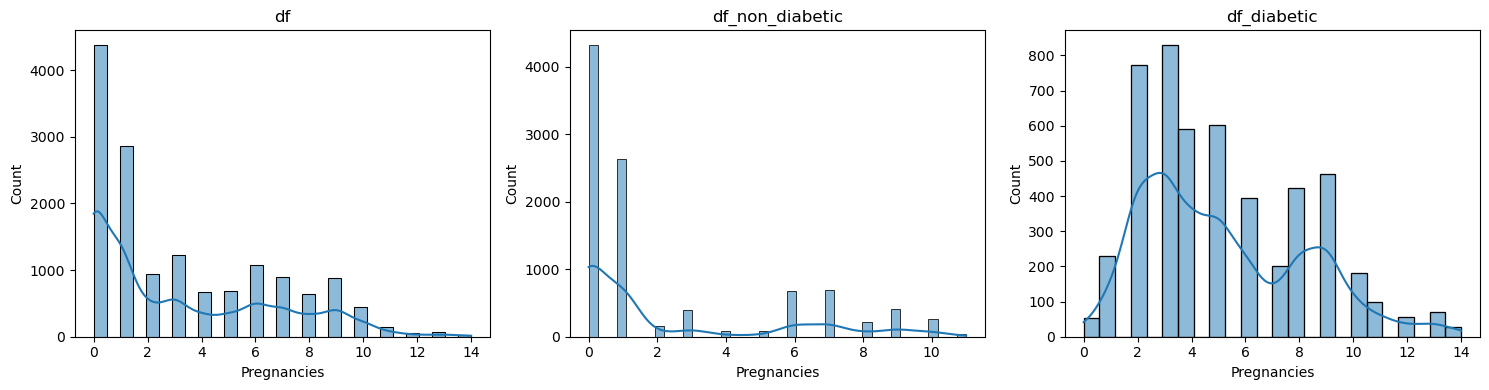

------------------------------
Comparison of data distributions for PlasmaGlucose:
------------------------------


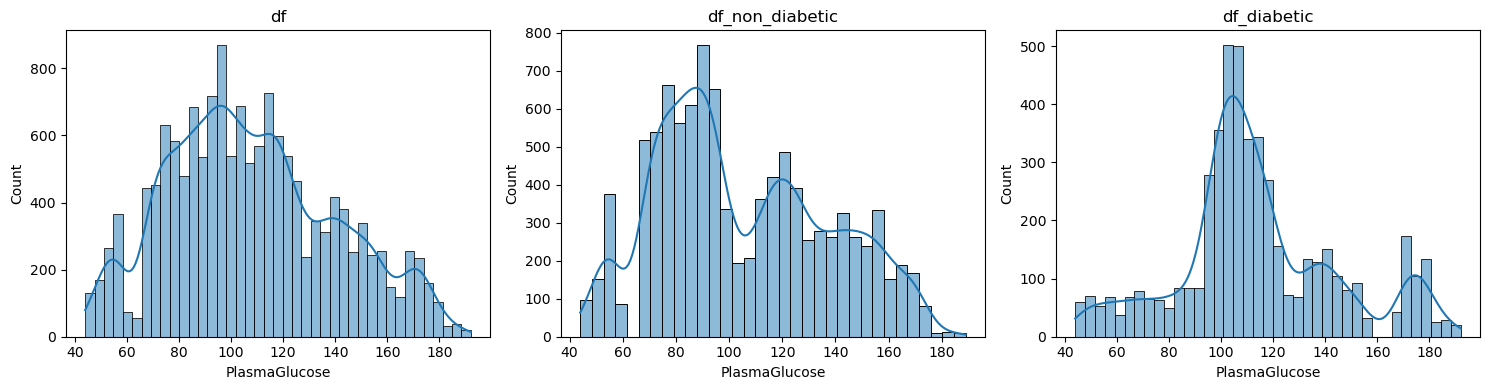

------------------------------
Comparison of data distributions for DiastolicBloodPressure:
------------------------------


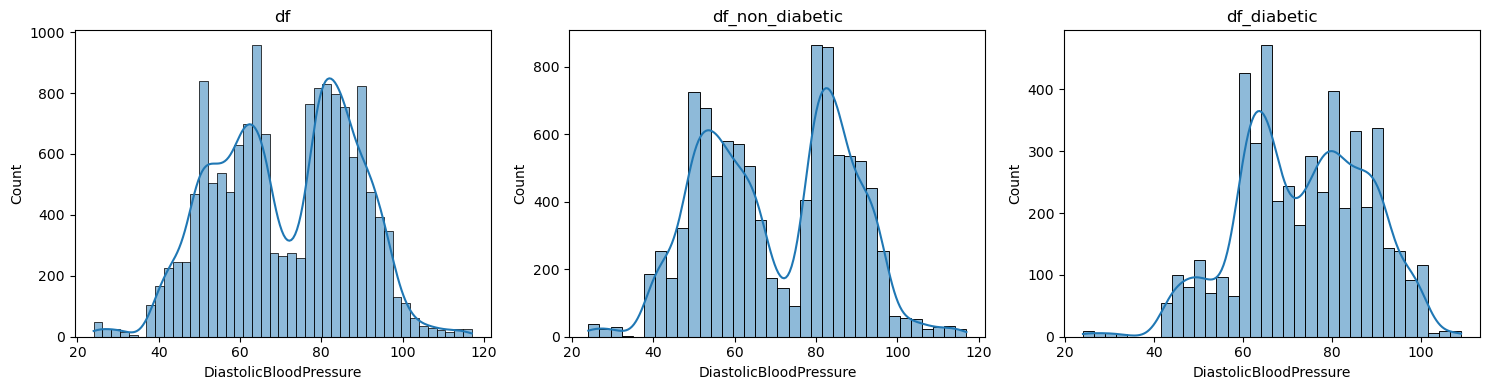

------------------------------
Comparison of data distributions for TricepsThickness:
------------------------------


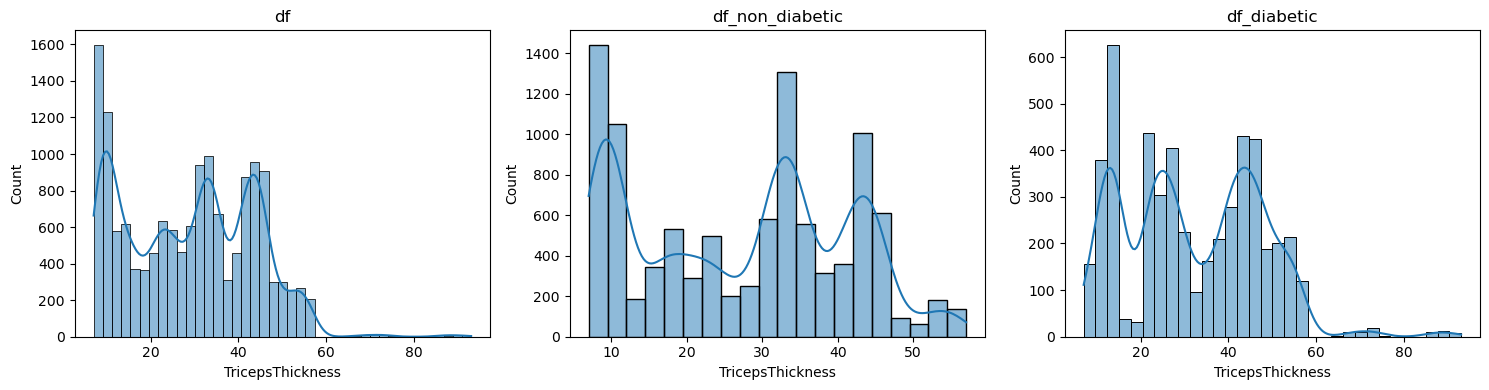

------------------------------
Comparison of data distributions for SerumInsulin:
------------------------------


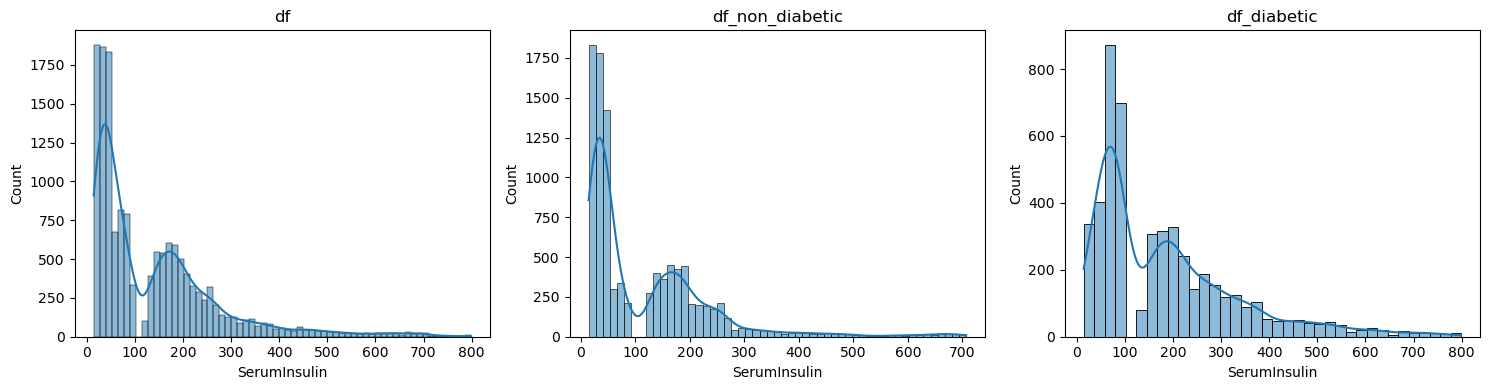

------------------------------
Comparison of data distributions for BMI:
------------------------------


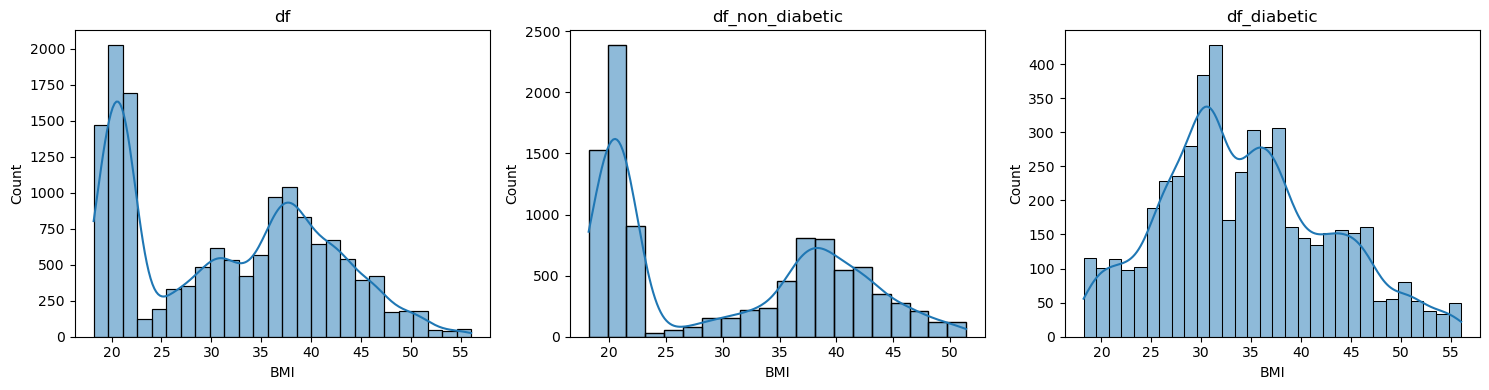

------------------------------
Comparison of data distributions for DiabetesPedigree:
------------------------------


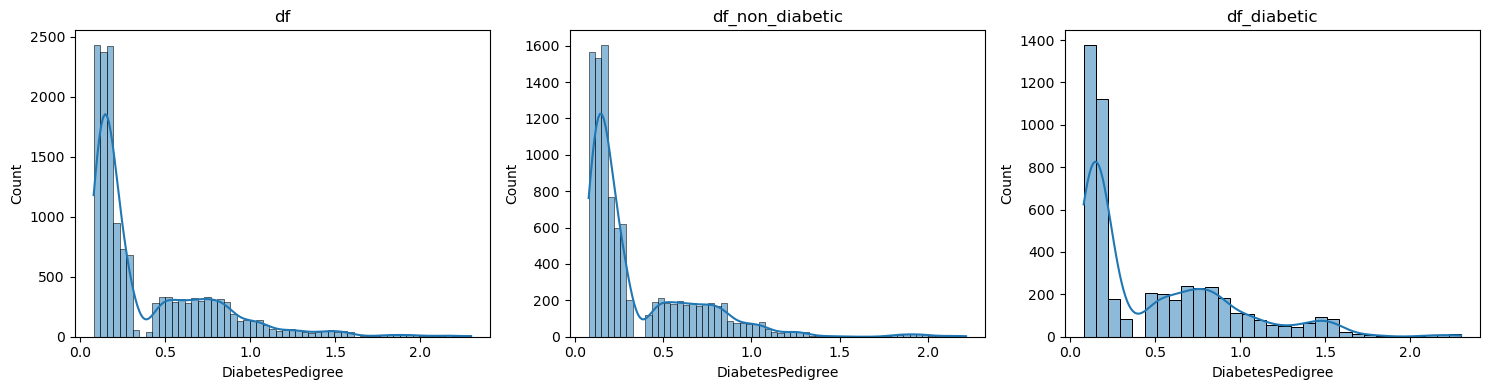

------------------------------
Comparison of data distributions for Age:
------------------------------


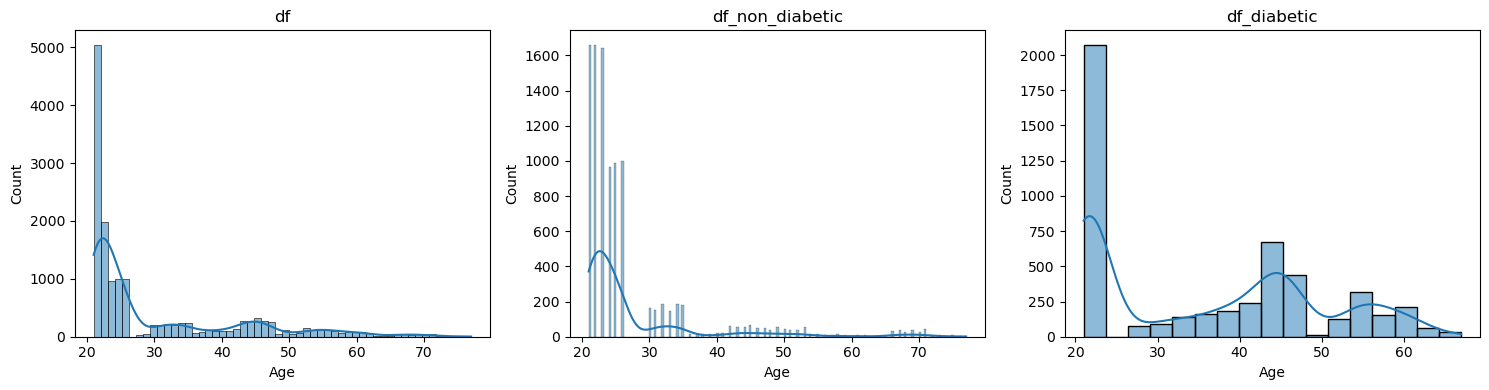

In [ ]:
# All data distributions
# Reset to Matplotlib's default style
plt.style.use("default")  # Restores the default Matplotlib style

for col in diabete_df.columns:
    if col != "PatientID" and col!= "Diabetic":
        compare_histograms_per_col([diabete_df, df_non_diabetic, df_diabetic], ["df", "df_non_diabetic", "df_diabetic"], col)

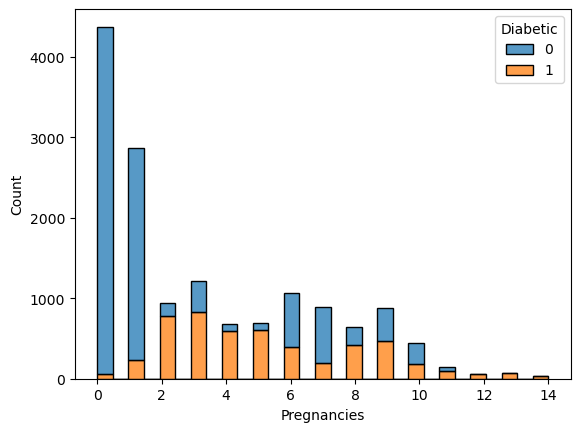

In [104]:
# Comparison of diabetic outcome vs. number of pregnancies
sns.histplot(data=diabete_df, x="Pregnancies", hue="Diabetic", multiple="stack")
plt.show()

#### **Pregnancies data observations**:

* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all values inside the range between 0 and 6, whereas the overall range is 0 to 14;
* diabetic group has a higher average pregnancy count (~5.2 vs. ~2.2 for non-diabetic);
* diabetic group: 50% of the sample has had ≤ 5 pregnancies (vs. 1 for  non-diabetics), and 75% has had ≤8 pregnancies (vs. 3 for non-diabetics);

#### **Pregnancies data implications**: 
* diabetes risk increases as the number of pregnancies grows.

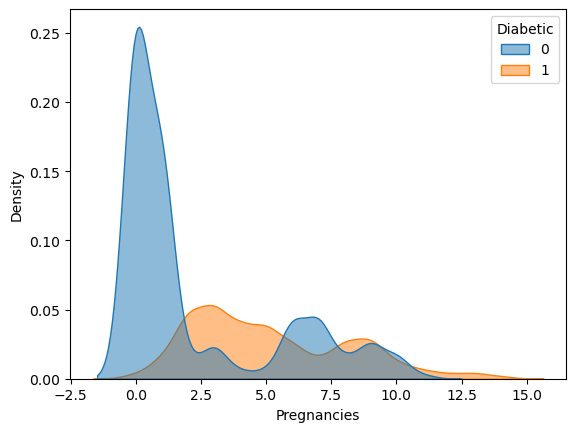

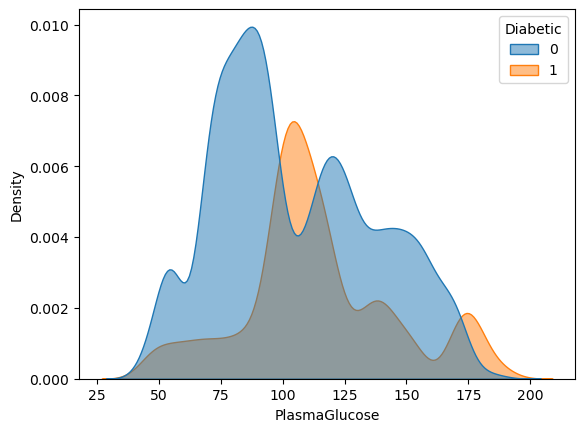

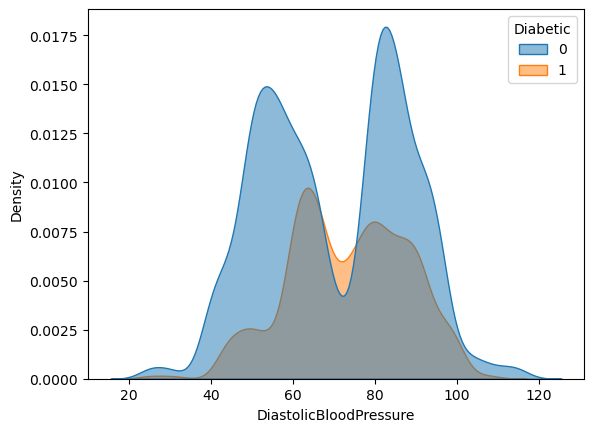

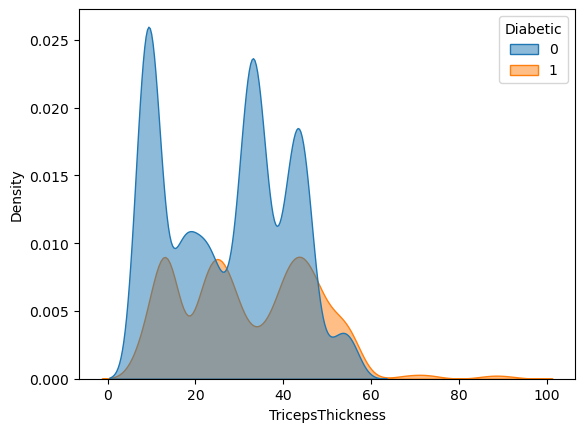

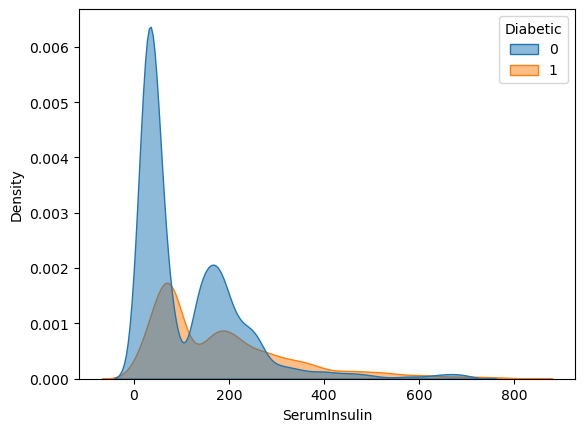

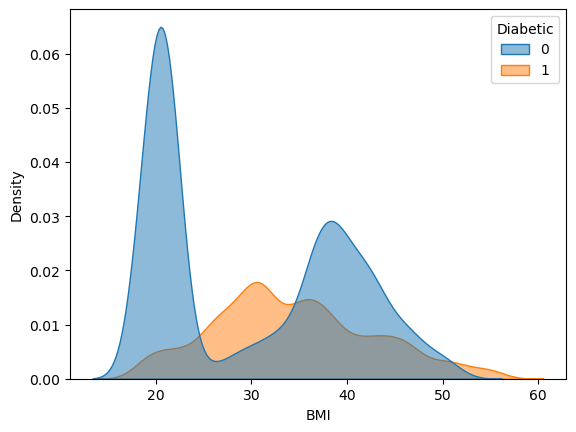

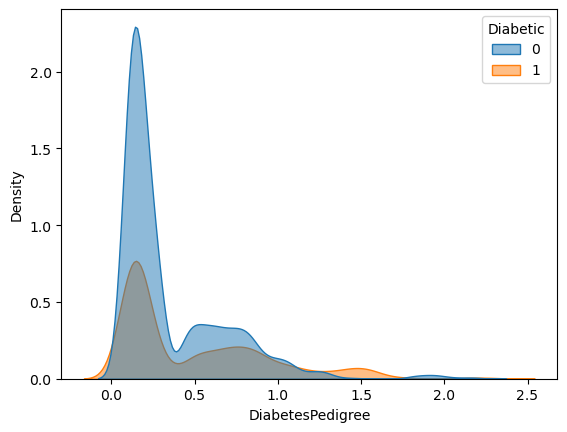

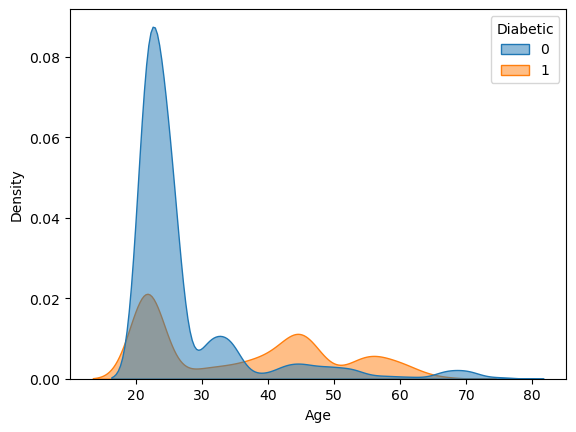

In [ ]:
# Comparison of diabetic outcome vs. column
for col_name in diabete_df.columns:
    if col_name != "PatientID" and col_name!= "Diabetic":
        sns.kdeplot(data=diabete_df, x=col_name, hue="Diabetic", fill=True, alpha=0.5)
    plt.show()

In [46]:
# Vérifier les dépendances des mesures médicales dans l'apparition du diabete  ==> Il y a un lien plus fort entre le vieillissement (Age) et l'apparition de Diabete et aussi entre le nombre de Grossesse et l'apparition du Diabete
# les mesures sont très peu correlées entre elles ==> donc on peut déduire que l'ensemble des colonne speuvent être utiles dans notre ML
# correlation entre l'age et la grossesse ==> laquelle des 2 est predominante dans l'apparition du diabete?
#Attention la correlation n'est pas la causalité

correlation = diabete_df.corr()
correlation

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
PatientID,1.000000,0.006774,-0.001858,0.008746,-0.002406,-0.020698,-0.003156,-0.015413,-0.007096,-0.012494
Pregnancies,0.006774,1.000000,0.054502,0.043528,0.063605,0.104487,0.086386,0.054240,0.136972,0.407315
PlasmaGlucose,-0.001858,0.054502,1.000000,0.007212,0.027100,0.033545,0.020653,0.009057,0.038864,0.128004
DiastolicBloodPressure,0.008746,0.043528,0.007212,1.000000,0.011106,0.022649,0.015873,0.014099,0.041333,0.091307
TricepsThickness,-0.002406,0.063605,0.027100,0.011106,1.000000,0.029688,0.024745,-0.000951,0.061383,0.152505
SerumInsulin,-0.020698,0.104487,0.033545,0.022649,0.029688,1.000000,0.051223,0.046324,0.088007,0.247375
BMI,-0.003156,0.086386,0.020653,0.015873,0.024745,0.051223,1.000000,0.028868,0.062910,0.210508
DiabetesPedigree,-0.015413,0.054240,0.009057,0.014099,-0.000951,0.046324,0.028868,1.000000,0.055633,0.170302
Age,-0.007096,0.136972,0.038864,0.041333,0.061383,0.088007,0.062910,0.055633,1.000000,0.342605
Diabetic,-0.012494,0.407315,0.128004,0.091307,0.152505,0.247375,0.210508,0.170302,0.342605,1.000000


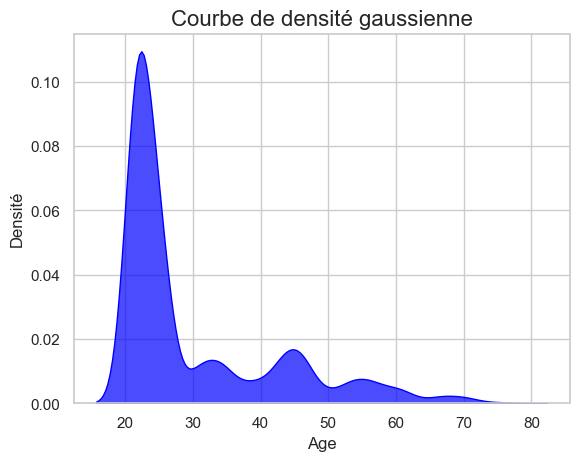

In [47]:
# objectif: focus sur l'age pour voir comment le set est construit. on peut constater que la grande majorité des données prélevées ce sont faites sur la tranche d'age de 20 à 3O ans


sns.set(style="whitegrid")
sns.kdeplot(diabete_df['Age'], fill=True, color="blue", alpha=0.7)

# Ajouter un titre et des labels
plt.title("Courbe de densité gaussienne", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Densité", fontsize=12)

# Afficher le graphique
plt.show()

In [48]:
age_inf_30 = diabete_df[diabete_df['Age'] <= 30.0]          # resultat = diabete_df[diabete_df['PlasmaGlucose'] > 140.0]['Diabetic']
age_inf_30.Age.describe()

count    10280.000000
mean        23.026751
std          1.960443
min         21.000000
25%         22.000000
50%         23.000000
75%         24.000000
max         30.000000
Name: Age, dtype: float64

In [49]:
age_30_40 = diabete_df[diabete_df['Age'] <= 40.0]
age_30_40 = age_30_40[age_30_40['Age'] > 30]        
age_30_40.Age.describe()

count    1554.000000
mean       34.622909
std         2.741612
min        31.000000
25%        32.000000
50%        34.000000
75%        37.000000
max        40.000000
Name: Age, dtype: float64

In [50]:
age_sup_35 = diabete_df[diabete_df['Age'] > 35.0]          
age_sup_35.Age.describe()

count    3633.000000
mean       49.380127
std         8.720514
min        36.000000
25%        43.000000
50%        46.000000
75%        55.000000
max        77.000000
Name: Age, dtype: float64

In [51]:
# 70% des plus de 35 ans ont le diabete .Donc l'age est assez déterminant dans cette analyse. et dans les moins de 22ans le taux est de 34%
# balancer cette analyse avec le nombre de grossesse


tranche_dage = [(0,22),(22,24),(24,35),(35,77)]
for i in tranche_dage:
    x,y = i
    age_x_y = diabete_df[diabete_df['Age'] > x]
    age_x_y = age_x_y[age_x_y['Age'] <=y]
    print("entre", x , "et", y,"ans, count",age_x_y.Diabetic.count())

    print("diabete",age_x_y.Diabetic.mean())


entre 0 et 22 ans, count 5042
diabete 0.34192780642602144
entre 22 et 24 ans, count 2956
diabete 0.11772665764546685
entre 24 et 35 ans, count 3369
diabete 0.10834075393291778
entre 35 et 77 ans, count 3633
diabete 0.705477566749243


In [52]:

# c'est sur ces 2 tranches d'age discuté plus haut que le nombre de grossesse moyenne est le plus élevé 

tranche_dage = [(0,22),(22,24),(24,35),(35,77)]
for i in tranche_dage:
    x,y = i
    age_x_y = diabete_df[diabete_df['Age'] > x]
    age_x_y = age_x_y[age_x_y['Age'] <=y]
    print("count ",age_x_y.Diabetic.count())
    print("pregnancies ",age_x_y.Pregnancies.mean())

    print("diabete",age_x_y.Diabetic.mean())

count  5042
pregnancies  3.2538675128917096
diabete 0.34192780642602144
count  2956
pregnancies  2.6275372124492558
diabete 0.11772665764546685
count  3369
pregnancies  2.5399228257643216
diabete 0.10834075393291778
count  3633
pregnancies  4.304431599229287
diabete 0.705477566749243


In [53]:
for i in range(diabete_df.Pregnancies.max()+1):
    Total_women_per_Pregnancies = diabete_df[diabete_df['Pregnancies'] == i]
    print(f"pour {i} grossesses : ",Total_women_per_Pregnancies.Diabetic.count(), "diabete ", Total_women_per_Pregnancies.Diabetic.mean())

pour 0 grossesses :  4377 diabete  0.012108750285583733
pour 1 grossesses :  2864 diabete  0.08030726256983241
pour 2 grossesses :  939 diabete  0.8242811501597445
pour 3 grossesses :  1219 diabete  0.6808859721082855
pour 4 grossesses :  675 diabete  0.8740740740740741
pour 5 grossesses :  687 diabete  0.87627365356623
pour 6 grossesses :  1070 diabete  0.37009345794392523
pour 7 grossesses :  895 diabete  0.22346368715083798
pour 8 grossesses :  645 diabete  0.6573643410852713
pour 9 grossesses :  881 diabete  0.5266742338251986
pour 10 grossesses :  450 diabete  0.40444444444444444
pour 11 grossesses :  143 diabete  0.6993006993006993
pour 12 grossesses :  57 diabete  1.0
pour 13 grossesses :  69 diabete  1.0
pour 14 grossesses :  29 diabete  1.0


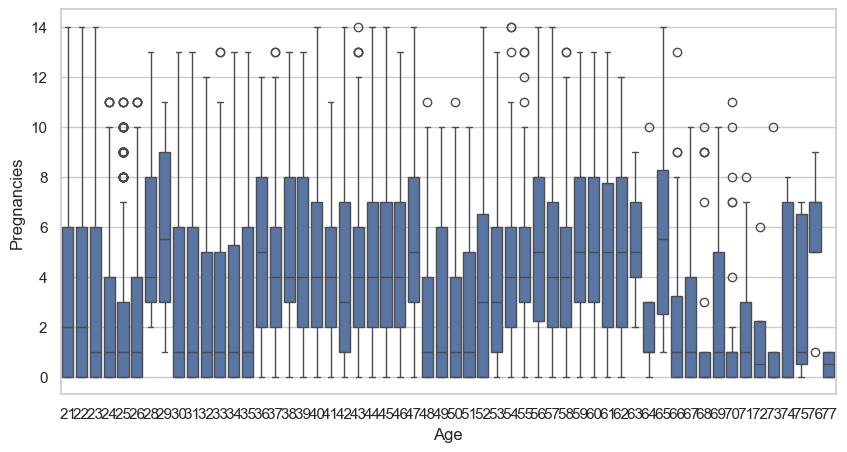

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,2.900000e+01,29.0,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.0
mean,1.508652e+06,14.0,122.310345,70.965517,34.000000,215.965517,35.696135,0.509534,34.275862,1.0
std,2.848301e+05,0.0,24.540205,14.383728,20.046375,178.932047,8.733631,0.441322,14.932937,0.0
min,1.017278e+06,14.0,70.000000,24.000000,9.000000,20.000000,18.453881,0.098536,21.000000,1.0
25%,1.333363e+06,14.0,107.000000,64.000000,21.000000,78.000000,30.665377,0.149536,22.000000,1.0
50%,1.445933e+06,14.0,118.000000,71.000000,30.000000,182.000000,35.803242,0.264857,23.000000,1.0
75%,1.723630e+06,14.0,137.000000,84.000000,43.000000,303.000000,40.253790,0.834632,47.000000,1.0
max,1.999765e+06,14.0,173.000000,92.000000,92.000000,682.000000,51.525250,1.528477,65.000000,1.0


In [54]:

plt.figure(figsize=(10,5))
sns.boxplot(x=diabete_df.Age,y=diabete_df.Pregnancies)
plt.show()
Total_women_per_Pregnancies = diabete_df[diabete_df['Pregnancies'] == 14]
Total_women_per_Pregnancies.describe()


In [55]:
# Suppression de la colonne 'PatientID'

diabete_df_dropID = diabete_df.drop(columns=['PatientID'])
#print(diabete_df)

# Vérifier les dimensions des tableaux
print(diabete_df_dropID.shape)

# Calcul de la moyenne et de la matrice de covariance
mean_vector = diabete_df_dropID.mean()
cov_matrix = np.cov(diabete_df_dropID.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

print(mean_vector.shape)  # Doit être de la forme (9,)
print(inv_cov_matrix.shape)

# Calcul de la distance de Mahalanobis pour trouver les éléments les plus éloignés de cette distance qui représenteraient les outliers. il y a 1144 lignes qui ont une distance de Mahalanobis >4
my_distance = diabete_df_dropID.apply(lambda row: mahalanobis(row, mean_vector, inv_cov_matrix), axis=1)

# Définition du seuil d'outlier (généralement, un seuil > 3 ou 4 est utilisé)
threshold = 4  # ou 4 selon la rigueur souhaitée
outliers = diabete_df_dropID[my_distance > threshold]

outliers


(15000, 9)
(9,)
(9, 9)


,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
30,11,75,89,8,541,29.422754,0.083732,47,1
33,3,123,61,29,46,28.091062,1.893404,25,0
47,9,104,51,7,24,27.369832,1.350472,43,1
48,6,73,61,35,24,18.743674,1.074148,75,0
67,4,104,68,91,250,27.871104,1.212582,50,1
...,...,...,...,...,...,...,...,...,...
14935,1,108,78,23,529,51.334246,0.100003,44,1
14938,1,114,81,10,127,46.677473,0.140449,70,0
14943,1,119,42,7,618,41.501977,0.156410,21,0
14952,13,96,66,48,48,36.174369,1.294610,39,1


In [56]:
outliers.describe()

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,4.450175,111.520979,71.709790,30.977273,302.369755,32.421127,0.753462,41.586538,0.455420
std,4.074670,37.319827,19.048762,18.472921,250.289433,10.336865,0.681631,19.274311,0.498226
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.203229,0.078093,21.000000,0.000000
25%,1.000000,83.000000,57.000000,13.750000,60.000000,21.595688,0.154101,23.000000,0.000000
50%,3.000000,106.000000,74.000000,31.000000,218.000000,32.039710,0.505248,39.000000,0.000000
75%,8.000000,141.000000,86.000000,44.000000,557.250000,40.156039,1.393429,61.000000,1.000000
max,14.000000,191.000000,116.000000,93.000000,799.000000,55.975311,2.301594,77.000000,1.000000


In [57]:
#outliers[outliers["Age"] == 21]   # parmis les outliers ceux qui ont 21 ans et il apparaît 1144 lignes
Nombre_de_grossesse = outliers[outliers["Age"] == 21]["Pregnancies"].unique()
print (Nombre_de_grossesse)
for i in sorted(Nombre_de_grossesse):
    outliers_21_i= outliers[outliers["Pregnancies"] == i ] #and outliers["Age"] == 21 ]  
    outliers_21_i = outliers_21_i [outliers_21_i["Age"] == 21 ]
    print ("grossesse", i, "nombre de femmes", len(outliers_21_i) )

[ 2  3  8  9  4  0 11 14  1  7 10  6  5 12 13]
grossesse 0 nombre de femmes 19
grossesse 1 nombre de femmes 18
grossesse 2 nombre de femmes 17
grossesse 3 nombre de femmes 14
grossesse 4 nombre de femmes 13
grossesse 5 nombre de femmes 9
grossesse 6 nombre de femmes 8
grossesse 7 nombre de femmes 3
grossesse 8 nombre de femmes 8
grossesse 9 nombre de femmes 20
grossesse 10 nombre de femmes 13
grossesse 11 nombre de femmes 8
grossesse 12 nombre de femmes 3
grossesse 13 nombre de femmes 2
grossesse 14 nombre de femmes 4


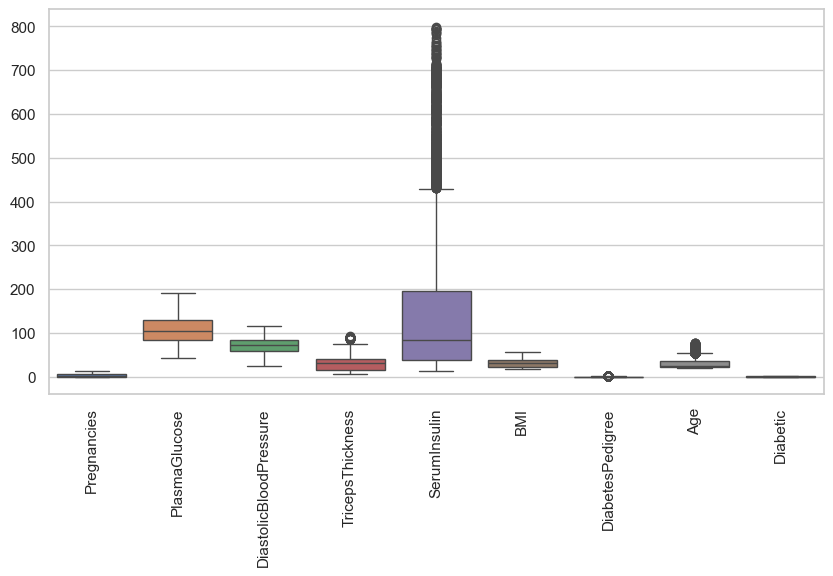

In [58]:
plt.figure(figsize=(10,5))
sns.boxplot(data=diabete_df_dropID)
plt.xticks(rotation=90)
plt.show()

In [59]:
z_scores = stats.zscore(diabete_df_dropID.select_dtypes(include=['float64', 'int64']))
outliers = (abs(z_scores) > 3).sum()
print(outliers)

Pregnancies                29
PlasmaGlucose               0
DiastolicBloodPressure      0
TricepsThickness           44
SerumInsulin              335
BMI                         0
DiabetesPedigree          254
Age                       218
Diabetic                    0
dtype: int64


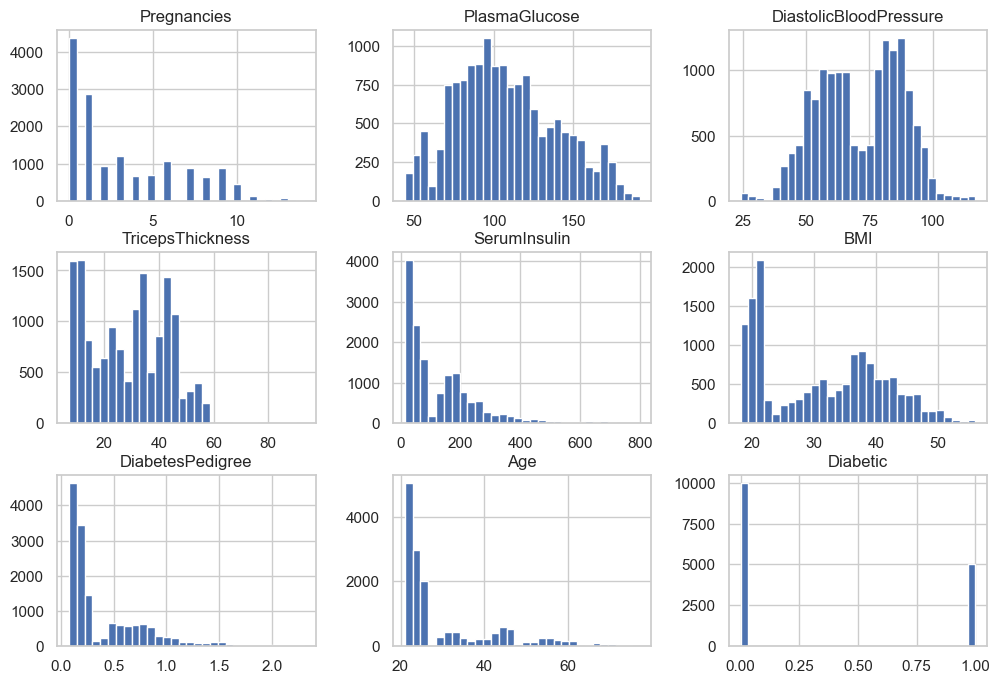

In [60]:
diabete_df_dropID.hist(figsize=(12,8), bins=30)
plt.show()

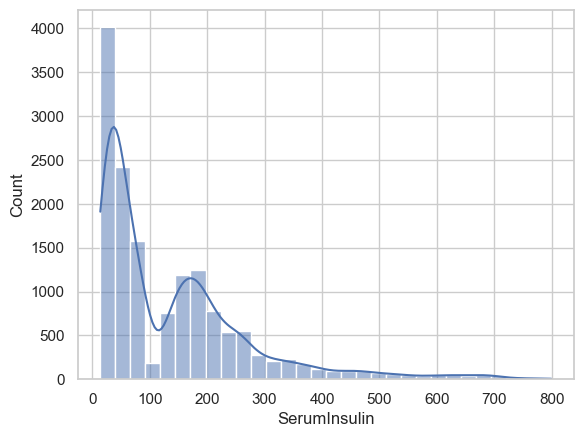

In [61]:
sns.histplot(diabete_df_dropID["SerumInsulin"], kde=True, bins=30)
plt.show()

In [62]:
Taux_Insuline_0 = diabete_df_dropID [diabete_df_dropID["SerumInsulin"]> 50]   # sur 15000 personnes environ 2/3 présentent une résistance à l'insuline donc une prédisposition au diabète
Taux_Insuline_0 

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
3,9,103,78,25,304,29.582192,1.282870,43,1
5,0,82,92,9,253,19.724160,0.103424,26,0
6,0,133,47,19,227,21.941357,0.174160,21,0
10,1,88,86,11,58,43.225041,0.230285,22,0
12,5,114,101,43,70,36.495320,0.079190,38,1
...,...,...,...,...,...,...,...,...,...
14995,10,65,60,46,177,33.512468,0.148327,41,1
14996,2,73,66,27,168,30.132636,0.862252,38,1
14997,0,93,89,43,57,18.690683,0.427049,24,0
14998,0,132,98,18,161,19.791645,0.302257,23,0


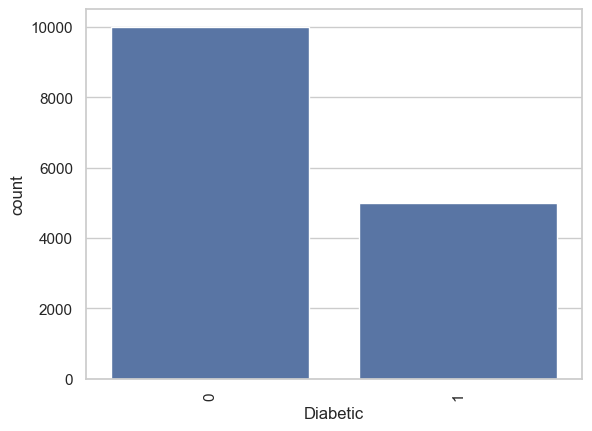

In [63]:
sns.countplot(x="Diabetic", data=diabete_df_dropID)
plt.xticks(rotation=90)
plt.show()

---
# **4. FEATURE ENGINEERING**
---

---
# **5. MODELS EVALUATION**
---